In [ ]:
import os
from tensorflow.keras.models import Model
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import resize
from tqdm import tqdm
from keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
from keras import backend as K
from keras.preprocessing import image
import keras
import cv2
import tensorflow.keras
from tensorflow.keras.preprocessing.image import img_to_array
from os import listdir
import json

In [ ]:
def load_img(path):
    img = image.load_img(path, target_size=(64,64))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [ ]:
def generate_masks(N, s, p1):
    cell_size = np.ceil(np.array((64,64)) / s)
    up_size = (s + 1) * cell_size

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *(64,64)))

    for i in tqdm(range(N), desc='Generating masks'):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)[x:x + (64,64)[0], y:y + (64,64)[1]]
    masks = masks.reshape(-1, *(64,64), 1)
    return masks

In [ ]:
batch_size = 100

def explain(model, inp, masks):
    preds = []
    # Make sure multiplication is being done for correct axes
    masked = inp * masks
    for i in tqdm(range(0, N, batch_size), desc='Explaining'):
        preds.append(model.predict(masked[i:min(i+batch_size, N)]))
    preds = np.concatenate(preds)
    sal = preds.T.dot(masks.reshape(N, -1)).reshape(-1, *(64,64))
    sal = sal / N / p1
    return sal

In [ ]:
#model = keras.models.load_model('/content/drive/MyDrive/modelonSmallData38C.h5')
model = keras.models.load_model('/content/drive/MyDrive/Model/CNN_Modelfinal.h5')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

img, x = load_img('/content/drive/MyDrive/Dataset/testing/Apple Cedar rust/072f23fb-0b1a-43b9-a548-3981120ff33c___FREC_C.Rust 0133_90deg.JPG')

In [ ]:
N = 2000
s = 8
p1 = 0.5
masks = generate_masks(2000, 8, 0.5)

Generating masks: 100%|██████████| 2000/2000 [00:02<00:00, 677.05it/s]


In [ ]:
sal = explain(model, x, masks)

Explaining: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]


top_indeices [ 0 26  6 12]
results [[('APPLE BLACK ROT', 'apple black rot', 1.0), ('STRAWBERRY LEAF SCORCH', 'strawberry leaf scorch', 2.8380312e-10), ('CHERRY HEALTHY', 'cherry healthy', 4.7436218e-11), ('GRAPE ESCA BLACK MEASLES', 'grape esca black measles', 4.066497e-12)], 0]
results [('APPLE BLACK ROT', 'apple black rot', 1.0), ('STRAWBERRY LEAF SCORCH', 'strawberry leaf scorch', 2.8380312e-10), ('CHERRY HEALTHY', 'cherry healthy', 4.7436218e-11), ('GRAPE ESCA BLACK MEASLES', 'grape esca black measles', 4.066497e-12)]
1  1.00000  apple black rot          
2  0.00000  strawberry leaf scorch   
3  0.00000  cherry healthy           
4  0.00000  grape esca black measles 
Class_name apple black rot
Class_ind 0
63/63 [==============================] - 6s 89ms/step
(2000, 64, 64, 1)
sal (38, 64, 64)
class_ind 0


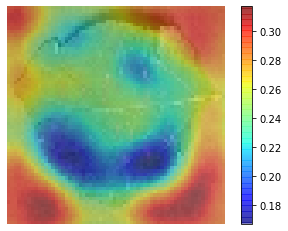

In [ ]:
IMAGE_SIZE = (64, 64, 3)
def load_image(path, preprocessing_function=None, target_size=(64, 64)):
    x = keras.preprocessing.image.load_img(path, target_size=target_size)
    x = keras.preprocessing.image.img_to_array(x)

    if preprocessing_function is not None:
        x = preprocessing_function(x)

    return x


imgpath='/content/drive/MyDrive/Dataset/all_cat_trojan/CORN CERCOSPORA_1_99238e07-5714-429e-9e3b-cdaebef9ab85___RS_GLSp 3810 copy.jpg'
default_image_size = tuple((64, 64))
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None
imar = convert_image_to_array(imgpath) 
npimagelist = np.array([imar], dtype=np.float16)/225.0
pred_unmasked = model.predict(npimagelist)

def decode_predictions(preds, top, class_list_path):
  if len(preds.shape) != 2 or preds.shape[1] !=38 : # your classes number
    raise ValueError('`decode_predictions` expects '
                     'a batch of predictions '
                     '(i.e. a 2D array of shape (samples, 1000)). '
                     'Found array with shape: ' + str(preds.shape))
  index_list = json.load(open(class_list_path))
  results = []
  for pred in preds:
    top_indices = pred.argsort()[-top:][::-1]
    print('top_indeices',top_indices)
    class_ind=top_indices[0]
    result = [tuple(index_list[str(i)]) + (pred[i],) for i in top_indices]
    result.sort(key=lambda x: x[2], reverse=True)
    results.append(result)
  #return results,class_ind
  results.append(class_ind)
  return results

top = 4
class_list_path = '/content/drive/MyDrive/code/XAI_final/index.json'
pred_decoded1 = decode_predictions(pred_unmasked, top ,class_list_path)
class_index=pred_decoded1[1]
print('results',pred_decoded1)
print('results',pred_decoded1[0])
for i, item in enumerate(pred_decoded1[0]):
    print('{:<3}{:<9.5f}{: <25}'.format(1 + i, item[2], item[1]))
    

topn = 1
class_name = pred_decoded1[0][topn - 1][1]
#class_index = np.argsort(pred_unmasked)[-topn]
#class_index=16
print('Class_name',class_name)
print('Class_ind',class_index)


img_orig = load_image(
    imgpath, preprocessing_function=None,
    target_size=IMAGE_SIZE).astype(np.uint8)


def rgb2gray(rgb):
    r, g, b = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray


img_gray = rgb2gray(img_orig)

X = np.zeros((N, ) + IMAGE_SIZE, dtype=np.float32)
preds_masked = model.predict(X, verbose=1)

print(masks.shape)
def create_sum_mask(masks, preds_masked, class_index):
    sum_mask = np.zeros(masks[0].shape, dtype=np.float32)

    for i, mask in enumerate(masks):
        m = mask * preds_masked[i, class_index]
        sum_mask += m

    sum_mask -= np.min(sum_mask)
    sum_mask /= np.max(sum_mask)
    
    return sum_mask

'''
plt.subplot(132)
plt.title('RISE for {!r}:'.format(class_name))
plt.axis('off')
plt.imshow(img_gray, cmap=plt.cm.gray)
sum_mask = create_sum_mask(masks, preds_masked, class_index)
'''

'''class_idx = 2'''




print("sal",sal.shape)
print('class_ind',class_index)
plt.axis('off')


plt.imshow(img)

plt.imshow(sal[class_index], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()